<a href="https://colab.research.google.com/github/GallardoCoriaMarcelo/Laboratorios/blob/main/2do_Parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2do Parcial (SIS420-COM300)**

Marcelo Daniel Gallardo Coria (Ing. en Diseño y Animación Digital)

**Temática** (lo que se quiere buscar con el dataset):  Segmentar diamantes por sus caracteristicas.

URL del Dataset: https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices/
Nombre: Diamonds Prices2022.csv

Montaje Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Cargar el conjunto de datos desde un archivo CSV
diamonds_data = pd.read_csv('/content/drive/MyDrive/Dataset_no_supervisado/2do_Parcial/Diamonds_Prices2022.csv')

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Eliminar columnas no necesarias
diamonds_data = diamonds_data.drop(['Unnamed: 0', 'price'], axis=1)

print(diamonds_data.head())  # Muestra las primeras filas del DataFrame
print(diamonds_data.info())  # Muestra información sobre las columnas y tipos de datos
print(diamonds_data.describe())  # Proporciona estadísticas descriptivas de los datos numéricos


   carat      cut color clarity  depth  table     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0  4.34  4.35  2.75
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53943 non-null  float64
 1   cut      53943 non-null  object 
 2   color    53943 non-null  object 
 3   clarity  53943 non-null  object 
 4   depth    53943 non-null  float64
 5   table    53943 non-null  float64
 6   x        53943 non-null  float64
 7   y        53943 non-null  float64
 8   z        53943 non-null  float64
dtypes: float64(6), object(3)
memory usage: 3.7+ MB
None
              carat         depth

ASIGNAMOS VALORES NUMERICOS A LOS VALORES CUALITATIVOS

In [4]:
# Obtener los valores únicos de las columnas "cut", "color" y "clarity"
unique_cut_values = diamonds_data['cut'].unique()
unique_color_values = diamonds_data['color'].unique()
unique_clarity_values = diamonds_data['clarity'].unique()

# Contar el número de valores únicos
num_unique_cut_values = len(unique_cut_values)
num_unique_color_values = len(unique_color_values)
num_unique_clarity_values = len(unique_clarity_values)

# Mostrar valores únicos en las columnas "cut", "color" y "clarity"
print(f'Valores únicos en la columna "cut": {unique_cut_values}')
print(f'Valores únicos en la columna "color": {unique_color_values}')
print(f'Valores únicos en la columna "clarity": {unique_clarity_values}')

print(f"Número de valores únicos en 'cut': {num_unique_cut_values}")
print(f"Número de valores únicos en 'color': {num_unique_color_values}")
print(f"Número de valores únicos en 'clarity': {num_unique_clarity_values}")

Valores únicos en la columna "cut": ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
Valores únicos en la columna "color": ['E' 'I' 'J' 'H' 'F' 'G' 'D']
Valores únicos en la columna "clarity": ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']
Número de valores únicos en 'cut': 5
Número de valores únicos en 'color': 7
Número de valores únicos en 'clarity': 8


In [5]:
# Definir el diccionario de mapeo
cut_mapping = {'Ideal': 5, 'Premium': 4, 'Good': 3, 'Very Good': 2, 'Fair': 1}
color_mapping = {'E': 0, 'I': 1, 'J': 2, 'H': 3, 'F': 4, 'G': 5, 'D': 6}
clarity_mapping = {'SI2': 1, 'SI1': 2, 'VS1': 3, 'VS2': 4, 'VVS2': 5, 'VVS1': 6, 'I1': 7, 'IF': 8}

# Crear una nueva columna 'cut_numeric' con los valores numéricos
diamonds_data['cut'] = diamonds_data['cut'].map(cut_mapping)
diamonds_data['color'] = diamonds_data['color'].map(color_mapping)
diamonds_data['clarity'] = diamonds_data['clarity'].map(clarity_mapping)

# Mostrar el DataFrame resultante
print(diamonds_data)


       carat  cut  color  clarity  depth  table     x     y     z
0       0.23    5      0        1   61.5   55.0  3.95  3.98  2.43
1       0.21    4      0        2   59.8   61.0  3.89  3.84  2.31
2       0.23    3      0        3   56.9   65.0  4.05  4.07  2.31
3       0.29    4      1        4   62.4   58.0  4.20  4.23  2.63
4       0.31    3      2        1   63.3   58.0  4.34  4.35  2.75
...      ...  ...    ...      ...    ...    ...   ...   ...   ...
53938   0.86    4      3        1   61.0   58.0  6.15  6.12  3.74
53939   0.75    5      6        1   62.2   55.0  5.83  5.87  3.64
53940   0.71    4      0        2   60.5   55.0  5.79  5.74  3.49
53941   0.71    4      4        2   59.8   62.0  5.74  5.73  3.43
53942   0.70    2      0        4   60.5   59.0  5.71  5.76  3.47

[53943 rows x 9 columns]


ESCALADO DE LOS DATOS

In [6]:
# Escalar los datos para que tengan media 0 y varianza 1
scaler = StandardScaler()
diamonds_data_scaled = scaler.fit_transform(diamonds_data)

# Mostrar el DataFrame resultante
print(diamonds_data_scaled)


[[-1.19818918  0.97078151 -1.5483143  ... -1.58788233 -1.5362387
  -1.57116638]
 [-1.24038379  0.18086286 -1.5483143  ... -1.64137165 -1.65882074
  -1.74121683]
 [-1.19818918 -0.60905579 -1.5483143  ... -1.49873345 -1.45743597
  -1.74121683]
 ...
 [-0.18551847  0.18086286 -1.5483143  ...  0.05245691  0.00479257
  -0.06905407]
 [-0.18551847  0.18086286  0.40273967 ...  0.00788248 -0.00396329
  -0.15407929]
 [-0.20661578 -1.39897445 -1.5483143  ... -0.01886218  0.02230429
  -0.09739581]]


REDUCIOS LA DIMENSIONALIDAD DE LAS CARACTERISTICAS

In [16]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
pca = pca.fit(diamonds_data_scaled)

explained_variance = pca.explained_variance_
print('Varianza por cada componente: ')
print(explained_variance)

#Varianza acumulada
PVE = pca.explained_variance_ratio_
print('Proporcion de Varianza Explicada por cada componente: ')
print(PVE)

#Criterio de varianza explicada
np.cumsum(pca.explained_variance_ratio_)

Varianza por cada componente: 
[4.08450955 1.36515032 1.17399991 0.99287283 0.86054139 0.42319935
 0.04703671 0.03978498 0.01307182]
Proporcion de Varianza Explicada por cada componente: 
[0.45382598 0.15168056 0.13044202 0.11031716 0.09561394 0.04702128
 0.0052262  0.00442047 0.0014524 ]


array([0.45382598, 0.60550654, 0.73594855, 0.84626571, 0.94187965,
       0.98890093, 0.99412713, 0.9985476 , 1.        ])

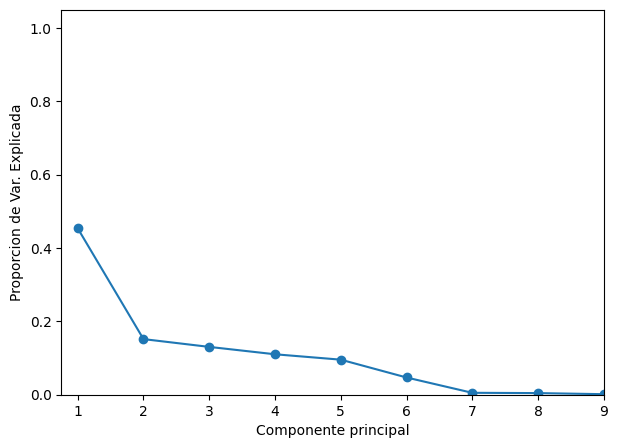

In [17]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6,7,8,9], pca.explained_variance_ratio_, '-o')
plt.ylabel('Proporcion de Var. Explicada')
plt.xlabel('Componente principal')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9])
plt.show()

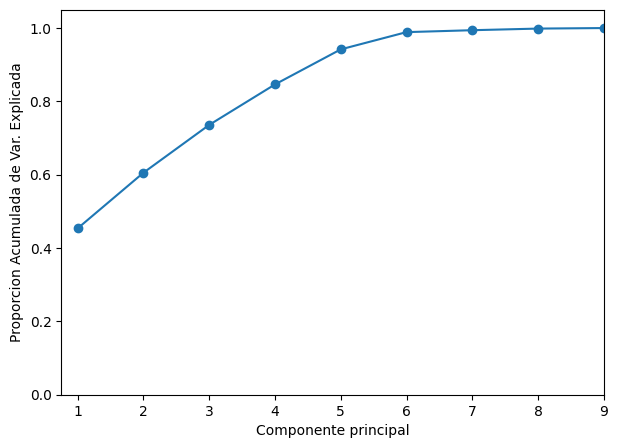

In [18]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6,7,8,9], np.cumsum(pca.explained_variance_ratio_), '-o')
plt.ylabel('Proporcion Acumulada de Var. Explicada')
plt.xlabel('Componente principal')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9])
plt.show()

CALCULAMOS LAS CARACTERISTICAS MAS RELEVANTES PARA EL MODELO, TOMAMOS 4 CARACTGERISTICAS

In [47]:
pca = PCA(n_components=4)
pca = pca.fit(diamonds_data_scaled)

explained_variance = pca.explained_variance_
print('Varianza por cada componente: ')
print(explained_variance)

#Varianza acumulada
PVE = pca.explained_variance_ratio_
print('Proporcion de Varianza Explicada por cada componente: ')
print(PVE)

#Criterio de varianza explicada
np.cumsum(pca.explained_variance_ratio_)

Varianza por cada componente: 
[4.08450955 1.36515032 1.17399991 0.99287283]
Proporcion de Varianza Explicada por cada componente: 
[0.45382598 0.15168056 0.13044202 0.11031716]


array([0.45382598, 0.60550654, 0.73594855, 0.84626571])

In [48]:
pca_loadings = pca.components_
#pd.DataFrame(pca_loadings, columns=diamonds_data.columns, index=['PC1','PC2','PC3','PC4','PC5']).head(7)
pca_scores = pca.transform(X)

In [50]:
df_plot = pd.DataFrame(pca_scores, columns=['PC1','PC2','PC3','PC4'], index=diamonds_data.index)
df_plot.head()

,PC1,PC2,PC3,PC4
0,-2.773897,-0.463428,0.042339,-1.750900
1,-2.648672,2.310209,0.827243,-1.601840
2,-2.271209,4.666955,2.223755,-1.504446
3,-2.458700,0.379055,-0.442640,-1.117326
4,-1.854767,0.718368,-1.627908,-0.537792


In [51]:
df_plot.corr()

,PC1,PC2,PC3,PC4
PC1,1.000000e+00,-4.319556e-16,4.602907e-16,-9.918992e-17
PC2,-4.319556e-16,1.000000e+00,2.077282e-16,-4.621450e-16
PC3,4.602907e-16,2.077282e-16,1.000000e+00,4.717746e-16
PC4,-9.918992e-17,-4.621450e-16,4.717746e-16,1.000000e+00


CALCULAMOS EL N° OPTIMO DE CLUSTERS

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

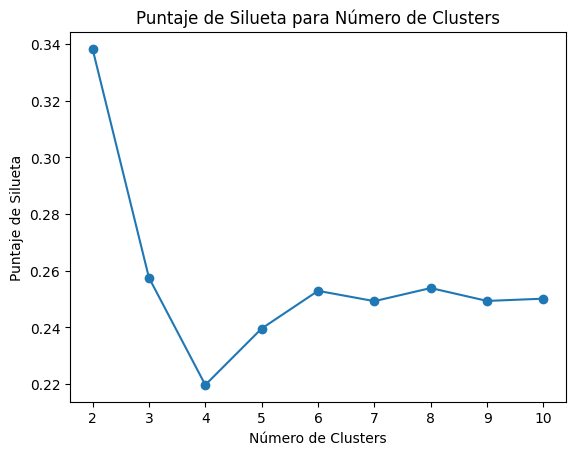

In [52]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in range(2, 11):  # Probamos desde 2 hasta 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_plot)
    silhouette_avg = silhouette_score(df_plot, cluster_labels)
    silhouette_scores.append(silhouette_avg)

import matplotlib.pyplot as plt

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntaje de Silueta')
plt.title('Puntaje de Silueta para Número de Clusters')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

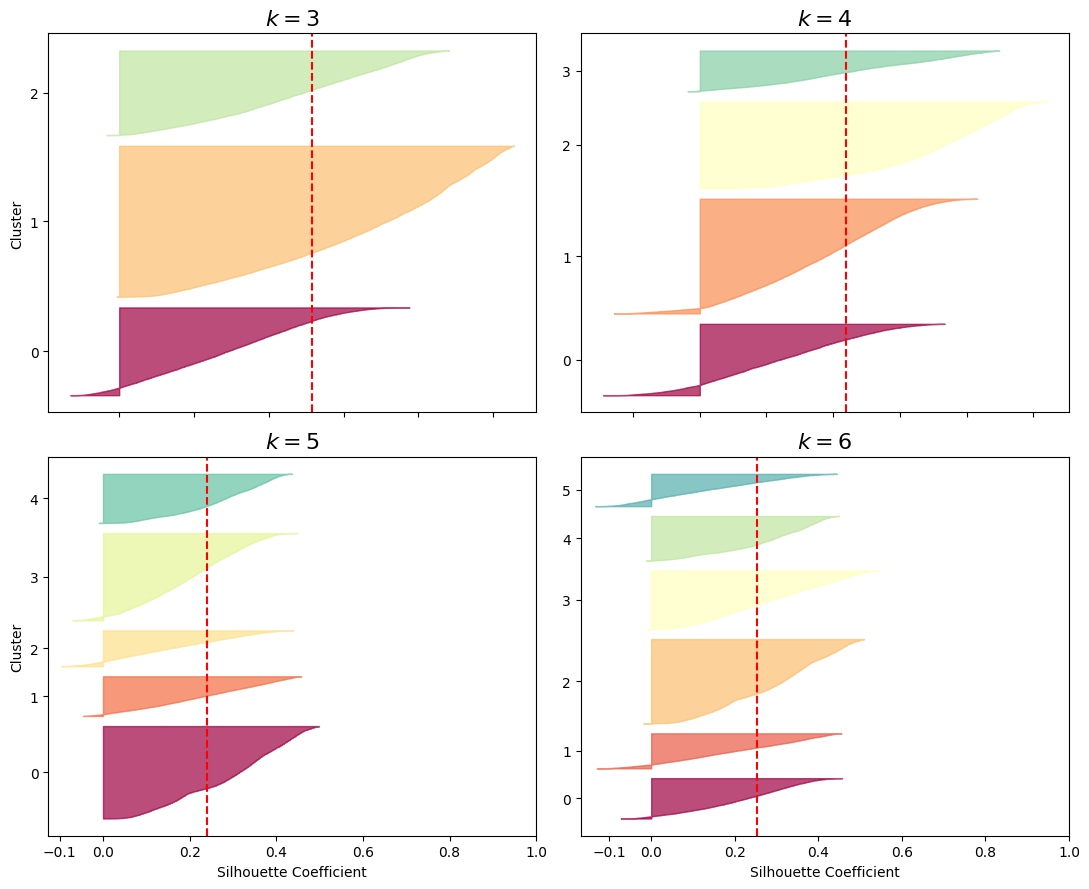

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter

# Asumimos que df_plot es el DataFrame con los datos
X = df_plot.values

# Ajustar modelos K-means para diferentes valores de k
kmeans_models = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    kmeans_models.append(kmeans)

# Calcular los puntajes de silueta para cada k
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_models]

# Visualización detallada de los coeficientes de silueta
plt.figure(figsize=(11, 9))

for idx, k in enumerate((3, 4, 5, 6), start=1):
    plt.subplot(2, 2, idx)

    y_pred = kmeans_models[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.tight_layout()
plt.show()


In [54]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)


0.25011230989318084

In [64]:
from sklearn.cluster import KMeans

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(df_plot)
y_pred

kmeans.cluster_centers_



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[-1.56207262, -0.01606855,  0.02584261, -0.02719212],
       [ 1.87568526,  0.01929459, -0.03103095,  0.0326514 ]])